# Ecuación de Difusión en 2D implementado en nubes de puntos.

Función que calcula una aproximación a la solución de la ecuación de Difusión en 2D utilizando Diferencias Finitas Generalizadas en nubes de puntos.

El problema que se resuelve es:

<center>$\frac{\partial u}{\partial t}= \nu\nabla^2 u$</center>

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    p           m x 2       double      Matriz con las coordenadas de los m nodos.
    pb          o x 2       double      Matriz con las coordenadas de los nodos frontera.
    vec         mxnvec      double      Matriz con la correspondencia de los vecinos de cada nodo.
    fDIF                    function    Función declarada con la condición inicial y de frontera.

### Parámetros de salida
    u_ap        m x 1       double      Vector con la aproximación calculada por el método.
    u_ex        m x 1       double      Vector con la solución exacta del problema.

In [3]:
# Se elige la nube en la que se va a trabajar
nube = 'CAB_2'

# Se elige el tamaño de la discretización temporal
t   = 2000

## Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones iniciales y de frontera.

### Importación de Librerias
En esta parte se importan las librerias necesarias para ejecutar todo el código. En particual se importan:

*   **numpy**. Para poder hacer la mayor parte de los cálculos numéricos.
*   **math**. Permite hacer uso de diferentes funciones matemáticas.
*   **matplotlib**. Para hacer las gráficas necesarias.
*   **scipy**. Para usar una gran cantidad de funciones matemáticas.

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import cv2
import glob
from scipy.io import loadmat
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $p$, $pb$ y $vec$.

In [5]:
# Se cargan todos los datos desde el archivo
mat = scipy.io.loadmat(nube + '.mat')

# Se guardan los datos de los nodos
p   = mat['p']
pb  = mat['pb']
vec = mat['vec']
nu  = 0.4

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(p[:,0],  p[:,1],  s = 5, label = 'interiores')
plt.scatter(pb[:,0], pb[:,1], s = 5, label = 'frontera')
plt.legend(loc='best')
plt.title('Nube de la región')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'CAB_2.mat'

### Se definen las condiciones iniciales y de frontera

Las condiciones iniciales y de frontera serán definidas como:
<center>
  $f = e^{-2*\pi^2vt}\cos(\pi x)cos(\pi y)$
</center>

In [ ]:
def fDIF(x, y, t, v):
  fun = math.exp(-2*math.pi**2*v*t)*math.cos(math.pi*x)*math.cos(math.pi*y)
  return fun

## Diferencias Finitas Generalizadas
En esta parte se implementa el método de Diferencias Finitas Generalizadas sobre nubes de puntos.

Se realizan las siguientes operaciones:

1.   Se calculan los valores de Gamma.
2.   Se hace el Método de Diferencias Finitas Generalizadas.

### Cálculo de Gammas

Se hace el cálculo de las Gammas, utilizando la Pseudoinversa de Moore Penrose.

In [ ]:
def Gammas(p, pb, vec, L):
  m     = len(p[:,0])                                                            # Se encuentra el número de nodos.
  mf    = len(pb[:,0])                                                           # Se encuentra el número de nodos frontera.
  Gamma = np.zeros([m, 9])                                                       # Se inicializa el arreglo para guardar las Gammas.

  for i in np.arange(mf, m):                                                     # Para cada uno de los nodos internos.
    nvec = sum(vec[i,:] != 0)                                                    # Se calcula el número de vecinos que tiene el nodo.
    dx = np.zeros([nvec])                                                        # Se inicializa dx en 0.
    dy = np.zeros([nvec])                                                        # Se inicializa dy en 0.

    for j in np.arange(nvec):                                                    # Para cada uno de los nodos vecinos.
      vec1 = int(vec[i, j])-1                                                    # Se obtiene el índice del vecino.
      dx[j] = p[vec1, 0] - p[i,0]                                                # Se calcula dx.
      dy[j] = p[vec1, 1] - p[i,1]                                                # Se calcula dy.

    M = np.vstack([[dx], [dy], [dx**2], [dx*dy], [dy**2]])                       # Se hace la matriz M.
    M = np.linalg.pinv(M)                                                        # Se calcula la pseudoinversa.
    YY = M@L                                                                     # Se calcula M*L.
    Gem = np.vstack([-sum(YY), YY]).transpose()                                  # Se encuentran los valores Gamma.
    for j in np.arange(nvec+1):                                                  # Para cada uno de los vecinos.
      Gamma[i,j] = Gem[0,j]                                                      # Se guarda el Gamma correspondiente.
  
  return Gamma

### Se implementa el método de Diferencias Finitas Generalizadas.

Se resuelve el problema de Diferencias Finitas Generalizadas. Desde aquí se manda a llamar a las rutinas para buscar vecinos y calcular las Gammas.

In [ ]:
def Diffusion_Cloud(p, pb, vec, f, nu, t):
  m    = len(p[:,0])                                                             # Se encuentra el número de nodos.
  mf   = len(pb[:,0])                                                            # Se encuentra el número de nodos de frontera.
  #mm   = len(p[np.arange(mf,m),0])                                               # Se encuentra el número de nodos interiores.
  T    = np.linspace(0,1,t)                                                       # Se hace la malla en el tiempo.
  dt   = T[1] - T[0]                                                             # Se calcula dt.
  tol  = np.finfo(float).eps                                                     # La tolerancia será eps.
  u_ap = np.zeros([m,t])                                                         # Se inicializa u_ap con ceros.
  u_ex = np.zeros([m,t])                                                         # Se inicializa u_ex con ceros.

  ## Condiciones de Frontera
  for k in np.arange(t):
    for i in np.arange(mf):                                                      # Para cada uno de los nodos de frontera.
      u_ap[i, k] = f(pb[i, 0], pb[i, 1], T[k], nu)                               # Se agrega la condición de frontera.
  
  ## Condición Inicial
  for i in np.arange(m):                                                         # Para cada uno de los nodos
    u_ap[i, 0] = f(p[i, 0], p[i, 1], T[0], nu)                                 # Se agrega la condición inicial

  # Ahora, se calculan las Gammas
  L = np.vstack([[0], [0], [2*nu*dt], [0], [2*nu*dt]])                           # Se asignan los valores para el operador diferencial.
  Gamma = Gammas(p, pb, vec, L)                                                  # Se calculan las Gammas.


  for k in np.arange(1,t):
    for i in np.arange(mf, m):
      utemp = 0
      nvec = sum(vec[i,:] != 0)                                                  # Se calcula el número de vecinos que tiene el nodo.
      for j in np.arange(1,nvec+1):
        utemp = utemp + Gamma[i,j]*u_ap[int(vec[i, j-1])-1, k-1]
      utemp = utemp + Gamma[i,0]*u_ap[i, k-1]
      u_ap[i,k] = u_ap[i, k-1] + utemp

  for k in np.arange(t):
    for i in np.arange(m):                                                       # Para cada uno de los nodos.
      u_ex[i,k] = f(p[i,0], p[i,1], T[k], nu)                                    # Se coloca la solución exacta.

  return u_ap, u_ex, vec

## Ejecución

En esta parte se ejecuta el código para obtener los resultados. También se grafica la solución.

In [ ]:
u_ap, u_ex, vec = Diffusion_Cloud(p, pb, vec, fDIF, nu, t)

### Graficación

Se grafican los resultados obtenidos para la solución approximada y exacta.

In [ ]:
step = math.ceil(t/1000)
min  = u_ex.min()
max  = u_ex.max()
T    = np.linspace(0,1,t)
fig  = plt.figure(figsize =(15, 5))
ax1  = fig.add_subplot(1,2,1, projection='3d')
ax2  = fig.add_subplot(1,2,2, projection='3d')
nom  = nube + '.avi'

for k in range(0,t,step):
  tin = float(T[k])
  plt.suptitle('Solución al tiempo t = %1.3f seg.' %tin)
  tri1 = ax1.plot_trisurf(p[:,0], p[:,1], u_ap[:,k])
  tri2 = ax2.plot_trisurf(p[:,0], p[:,1], u_ex[:,k])
  ax1.set_zlim([min, max])
  ax1.set_title('Solución Aproximada')
  ax2.set_zlim([min, max])
  ax2.set_title('Solución Exacta')
  fig.canvas.draw()
  
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  ima = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  
  if k == 0:
    height, width, layers = ima.shape
    size = (width,height)
    out = cv2.VideoWriter(nom,cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
  
  out.write(ima)

  if k < t-step:
    ax1.cla()
    ax2.cla()

out.release()

NameError: ignored

### Error
Se calcula y muestra el error cometido

In [ ]:
def PolyArea(x,y):
  return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
def ECM_cloud(p, vec, u_ap, u_ex):
  m    = len(p[:,0])                                                             # Se encuentra el tamaño de la triangulación.
  t    = len(u_ap[1,:])                                                          # Se encuentra la cantidad de pasos en el tiempo.
  er   = np.zeros(t)                                                             # Se inicializa la variable para guardar el error.
  area = np.zeros(m)                                                             # Se inicializa la variable para guardar el área.

  for i in np.arange(m):
    nvec = sum(vec[i,:] != 0)                                                    # Se calcula el número de vecinos que tiene el nodo.
    polix = np.zeros([nvec])
    poliy = np.zeros([nvec])
    for j in np.arange(nvec):
      vec1 = int(vec[i,j])-1
      polix[j] = p[vec1,0]
      poliy[j] = p[vec1,1]
    area[i] = PolyArea(polix, poliy)


  for k in np.arange(t):  
    for i in np.arange(m):
      er[k] = er[k] + area[i]*(u_ap[i,k] - u_ex[i,k])**2                         # Se calcula el error en el nodo.
    
    er[k] = math.sqrt(er[k])                                                     # Se calcula la raiz cuadrada.
  
  return er

In [ ]:
def graphEr(er):
  T = np.linspace(0,1,t);
  plt.plot(T,er)
  plt.ylabel('Error')
  plt.xlabel('Tiempo en segundos')
  plt.title('Error cometido en el método')

El error máximo cometido para el método es de:  1.0836536706377877e-05


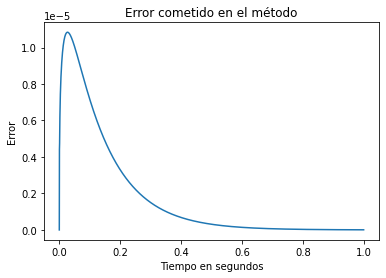

In [ ]:
er = ECM_cloud(p, vec, u_ap, u_ex)
print('El error máximo cometido para el método es de: ', er.max())
graphEr(er)